# MDCS REST api demo -- data from Diffusion couple

In [1]:
import pip

requires = ['numpy','xmltodict']

installed_packages = pip.get_installed_distributions()
installed_packages_list = sorted(["%s==%s" % (i.key, i.version) for i in installed_packages])

matching = [[libs for libs in installed_packages_list if x in libs] for x in requires]

if len(matching) == len(requires):
    print "requirement fullfilled"
else:
    print "something is missing"

requirement fullfilled


NOTE: if the check is failed, execute the following cell

In [ ]:
#!conda install numpy
#!pip install xmltodict

In [2]:
import os

file_check = ['DataModelDict.py','GE-DiffusionCouple-IN100-IN718.xml','GE-DiffusionCouple-IN718-R95.xml'
              ,'GE-DiffusionCouple-R88-R95.xml','mdcs','data','fig']

files = os.listdir(".")
matching = filter(None, [[fs for fs in files if x in fs] for x in file_check])


if len(matching) == len(file_check):
    print "files in the folder"
else:
    print "something is missing"

files in the folder


In [3]:
# standard python libraries
import numpy as np
import glob
import requests
import xmltodict

# -------------------------------------------- Matplotlib for plotting
                                          # NEED to be installed (anaconda)
# http://matplotlib.org/
import matplotlib.pyplot as plt
import matplotlib.colorbar as clb
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from matplotlib.ticker import LogLocator
%matplotlib inline


# customized library by Zachary Trautt
import mdcs
# customized library by Lucas Hale
from DataModelDict import DataModelDict

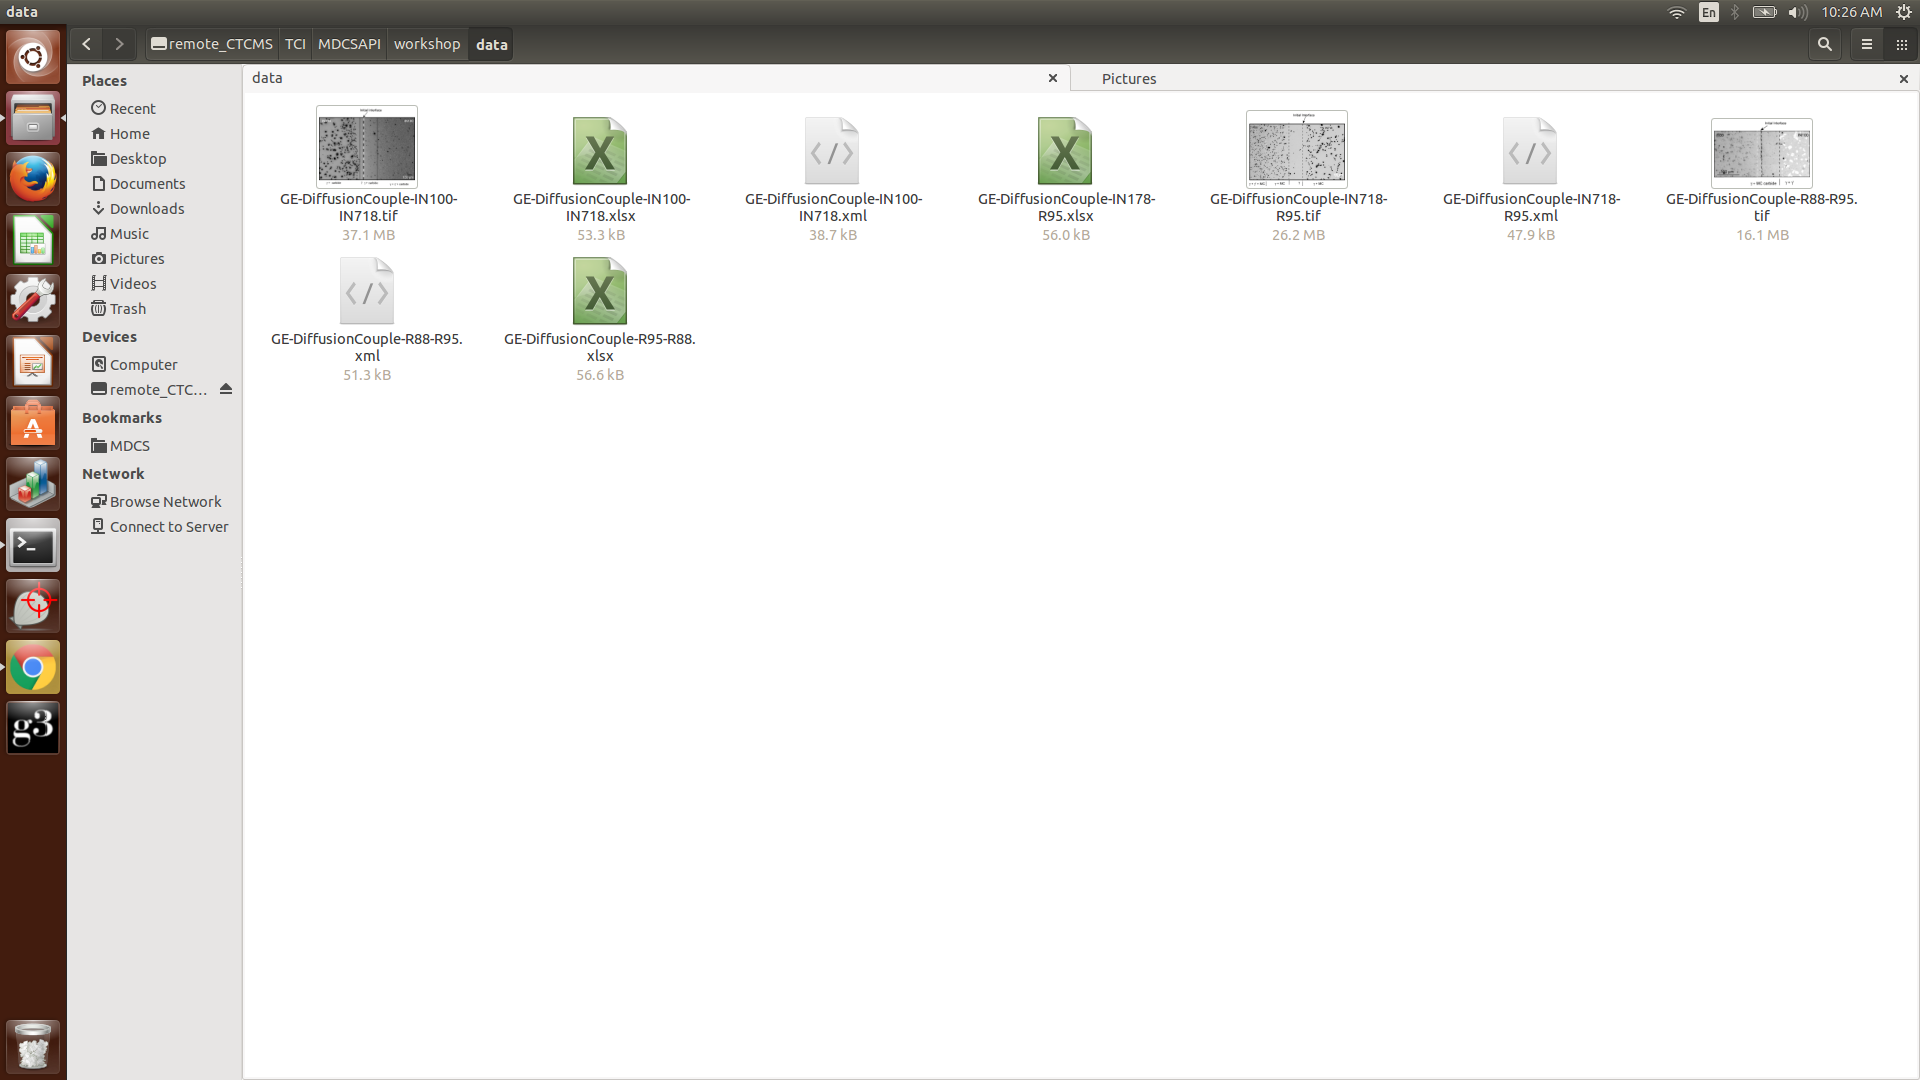

In [4]:
from IPython.display import Image
Image("fig/file_problem.png", width=600)

## How to manage .xml and image files? -- theupdate files are prepared in the folder "data"
### steps:
### (1) upload the draft XMLs
### (2) upload image files
### (3) query the data in MDCS
### (4) update the content with image URL
### (5) delete the draft XMLs from MDCS
### (6) upload the updated XMLs

In [5]:
# ---- setup user information to sign in MDCS
USER = "admin"
PSWD = "admin"
MDCS_URL = "http://127.0.0.1:8000"

### obtain the file names

In [7]:
xml_files = glob.glob("data/*.xml")
print "Files:  ",len(xml_files), xml_files

filetitle = []
xmlfile = []
fig_files = []

for i in range(len(xml_files)):
    filetitle.append(xml_files[i][5:-4])
    fig_files.append(str(xml_files[i][0:len(xml_files[i])-3] + 'tif'))

print "XML files: ",filetitle
print "Image files: ",fig_files

Files:   3 ['data/GE-DiffusionCouple-R88-R95.xml', 'data/GE-DiffusionCouple-IN718-R95.xml', 'data/GE-DiffusionCouple-IN100-IN718.xml']
XML files:  ['GE-DiffusionCouple-R88-R95', 'GE-DiffusionCouple-IN718-R95', 'GE-DiffusionCouple-IN100-IN718']
Image files:  ['data/GE-DiffusionCouple-R88-R95.tif', 'data/GE-DiffusionCouple-IN718-R95.tif', 'data/GE-DiffusionCouple-IN100-IN718.tif']


### Using blob function to upload the image files and return the URL

In [8]:
figURL = []

for i in range(len(xml_files)):
    figURL.append(mdcs.blob.upload(fig_files[i],MDCS_URL,USER,PSWD,'cert'))

print figURL

[u'http://127.0.0.1:8000/rest/blob?id=5720f57a1ff0f31620f6cc42', u'http://127.0.0.1:8000/rest/blob?id=5720f57b1ff0f31620f6cc81', u'http://127.0.0.1:8000/rest/blob?id=5720f57b1ff0f31620f6cce7']


### upload the XML files
make suer the template_title is correct on your MDCS instance

In [9]:
for i in range(len(xml_files)):
    print mdcs.curate_as(xml_files[i],filetitle[i],MDCS_URL, \
        USER,PSWD,'cert',template_title="mod_demo_diffusion0224")

created
created
created


### demo the function "query" to search the data by filetitles in database: 
###(1) the data content is stored in python list "qres" 
###(2) the specific "id" assigned by MDCS is kept in file_id

In [10]:
qres = []
file_id = []

for i in range(len(xml_files)):
    content = mdcs.explore.query(MDCS_URL,USER,PSWD,'cert',  \
                                 None,str({'title':filetitle[i]}))
    qres.append(xmltodict.parse(content[0]['content']))
    file_id.append(content[0]['_id'])


### update XML files with image URL

In [11]:
res = []

for i in range(len(xml_files)):
    qres[i]['experiment']['experimentType']['chemicalDiffusivity'] \
    ['dataAnalysis']['micrographOfStructure']['fileExtension'] = figURL[i]
    res.append(xmltodict.unparse(qres[i]))


## output the content as new XMLs
### WARNING: Occassionally, Jupyter may cause issues to output large file. You may try to run this cell multiple times.

In [12]:
filename = []

# write information to interdiffusion.xml
for i in range(len(xml_files)):
    filename.append(str(filetitle[i] + str('.xml')))
    diffusion = open(filename[i], 'w')
    diffusion.write(res[0].encode('utf8'))
    diffusion.close()

## delete the old XMLs in MDCS

In [13]:
for i in range(len(xml_files)):
    mdcs.explore.delete(file_id[i],MDCS_URL,USER,PSWD,cert=None)

## upload the revised XMLs

In [14]:
for i in range(len(xml_files)):
    print filename[i],mdcs.curate_as(filename[i],filetitle[i]
    ,MDCS_URL,USER,PSWD,'cert',template_title="mod_demo_diffusion0224")

GE-DiffusionCouple-R88-R95.xml created
GE-DiffusionCouple-IN718-R95.xml created
GE-DiffusionCouple-IN100-IN718.xml created


## Vidualize data
### query, load, and plot the data

In [15]:
content = mdcs.explore.query(MDCS_URL,USER,PSWD,'cert',
                             None,str({'title':filetitle[0]}))
qdata = DataModelDict(content[0]['content'])

table = qdata.find('table')

In [16]:
distable = []

for row in table['rows'].iterlist('row'):
    disrow = []
    for column in row.iterlist('column'):
        disrow.append(column['#text'])

    distable.append(disrow)

del distable[0]


## Plot the data

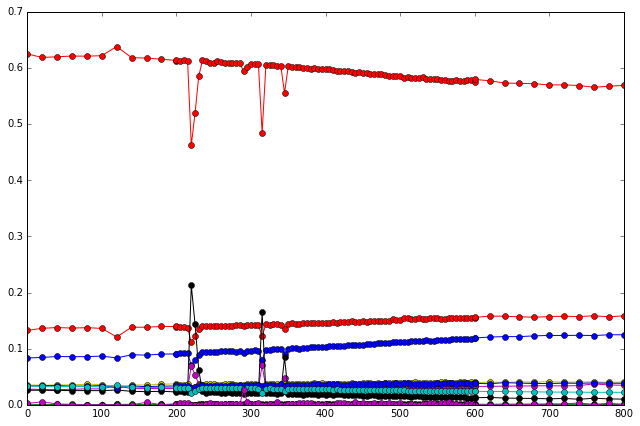

In [17]:
distable = np.array(distable)

fig, ax = plt.subplots(figsize=(9, 6))
for i in range(2,len(distable[0])):
    ax.plot(distable[:,0],distable[:,i],'o-')

fig.tight_layout()
plt.show()
